IHC - Adding the Inner Hair Cell model
===

This notebook is based on Chapter 18 of the [Human and Machine Hearing book](http://www.machinehearing.org) by Dick Lyon. Page numbers in the code comments refer to the pages of the Author’s 2018 corrected manuscript of this book.

Notebook by André van Schaik, [International Centre for Neuromorphic Systems](https://www.westernsydney.edu.au/icns).

Following on from the previous notebook on [the CARFAC model](./CARFAC.ipynb), we now incorporate the Inner Hair Cell model too. 

The Inner Hair Cell (IHC) model is shown here:

<p align="center"><img src="./images/IHC.png" alt="IHC" style="width: 800px;"></p>

First, the output of the BM filters is high-pass filtered at about 20Hz before being passed through a nonlinearity. A feedback loop provides  gain adaptation that causes the IHC to respond more strongly to the onset of a stimulus than the sustained part of that stimulus. Finally, the output of the IHC is low pass filtered to reduce the IHC's response to frequencies above 8kHz.



The nonlinear function in the IHC has two components. First an offset is added to the high-pass filtered BM signal $x$ and the result is half-wave rectified. This is then passed through a saturating nonlinearity. The two constants ($0.175$ and $0.1$) are part of the design of the nonlinear function.

\begin{aligned}
u&=\operatorname{HWR}(x+0.175) \\
g&=\frac{u^3}{u^3+u^2+0.1}
\end{aligned}

Here, we run into our first problem for simulation: $g$ is a variable that is already used in the BM filter, so we will need to give it a different name in our code below. Dick calls it $g$ because he describes it as a conductance of a neurotransmitter reservoir, with $v$ representing a voltage modelling how much transmitter is available in the reservoir. This results in a neurotransmitter current $y$:

$$
y=g v
$$

This neurotransmitter current is then low-pass filtered with a $10 ms$ filter to model the amount of neurotransmitter used from the reservoir ($q_{\text {NEW }}$ and $q$ below - these are the same variable but representing a filter update step), which is then subtracted from the maximum amount of transmitter available, which has been normalised at $1$:

\begin{aligned}
q_{\text {NEW }}&=q+a(c y-q) \\
v&=1-q
\end{aligned}

Finally, the neurotransmitter current $y$ is low-pass filtered twice, with a time constant of $80 \mu s$. This filtering models the diffusion of the neurotransmitter into the synaptic cleft, and is used as the IHC output signal NAP.

I have a slightly different interpretation of the model (the result is the same), which I use to change the names of the variables. In my interpretation, the output of the nonlinear function represents the IHC's membrane potential, which acts as a gain on neurotransmitter release.

\begin{aligned}
u &= \operatorname{HWR}(\text{BM}_{hpf} + 0.175) \\
v_{mem} &= \frac{u^3}{u^3 + u^2 + 0.1} \\
t_{released} &= v_{mem} \; t_{reservoir} \\
t_{used} &= (1 - a_{res}) t_{used} + a_{res} (c \; t_{released}) \quad \text{this is an update}\\
t_{reservoir} &= 1 - t_{used}
\end{aligned}

First, we define the CARFAC parameters and stimulus as before.

In [1]:
%matplotlib widget
from pylab import *
from scipy import signal

fs = 48000.0                        # sample frequency
dur = 2                             # simulation duration
npoints = int(fs * dur)             # stimulus length

# create a log-sine-sweep
f0 = 20                             # sweep start frequency
f1 = 20000                          # sweep end frequency
t1 = arange(npoints) / fs           # sample times
gain = 0.1                          # gain of input signal
stimulus = gain * signal.chirp(t1, f0, t1[-1], f1, method='logarithmic', phi=-90)

nsec = 100                          # number of sections in the cochlea between
xlow = 0.1                          # lowest frequency position along the cochlea and
xhigh = 0.9                         # highest frequency position along the cochlea
x = linspace(xhigh, xlow, nsec)     # position along the cochlea 1 = base, 0 = apex
f = 165.4 * (10**(2.1 * x) - 1)     # Greenwood for humans
a0 = cos(2 * pi * f / fs)           # a0 and c0 control the poles and zeros
c0 = sin(2 * pi * f / fs)

damping = 0.4                       # damping factor
r = 1 - damping * 2 * pi * f / fs   # pole & zero radius (actual)
r1 = 1 - damping * 2 * pi * f / fs  # pole & zero radius minimum (set point)
h = c0                              # p285 h = c0 puts the zeros 1/2 octave above poles
g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)
                                    # p285 this gives 0dB DC gain for BM
scale = 0.1                         # p297 NLF parameter
offset = 0.04                       # p297 NLF parameter
b = 0.3                             # automatic gain loop feedback (1=no undamping).
d_rz = 0.7 * (1 - r1)               # p294 relative undamping


Next we add the variables and constants we need for the IHC model. Some use different names than in the book, to avoid confusion.

In [2]:
# add IHC variables and constants
f_hpf = 20                              # p313 20Hz corner for the BM HPF
c_hpf = 1 / (1 + (2 * pi * f_hpf / fs)) # corresponding IIR coefficient 
c = 20
tau_res = 10e-3                         # p314 transmitter creation time constant
a_res = 1 / (fs * tau_res)              # p314 corresponding IIR coefficient    
tau_IHC = 80e-6                         # p314 ~8kHz LPF for IHC output
c_IHC = 1 / (fs * tau_IHC)              # p314 corresponding IIR coefficient 

Before we run the simulation, we initialise the variables as needed.

In [3]:
W = zeros(nsec)                     # BM filter internal state
V = zeros(nsec)                     # BM filter internal state
Vold = zeros(nsec)                  # BM filter internal state at t-1
BM = zeros((nsec, npoints))         # BM displacement
BM_hpf = zeros((nsec, npoints))     # BM displacement high-pass filtered at 20Hz
t_used = zeros(nsec)                # transmitter used 
t_reservoir = ones(nsec)            # transmitter available
IHC = zeros((nsec, npoints))        # IHC output
IHCa = zeros((nsec, npoints))       # IHC filter internal state
BM[-1] = stimulus                   # put stimulus at BM[-1] to provide input to BM[0]
BM[-1, -1] = 0                      # hack to make BM_hpf[nsec-1,0] work


Finally we simulated the whole system for each sample time and for all cochlear sections.

In [4]:
for t in range(npoints):
    for s in range(nsec):
        Wnew = BM[s - 1, t] + r[s] * (a0[s] * W[s] - c0[s] * V[s])
        V[s] = r[s] * (a0[s] * V[s] + c0[s] * W[s])
        W[s] = Wnew
        BM[s, t] = g[s] * (BM[s-1, t] + h[s] * V[s])
    v_OHC = V - Vold
    Vold = V.copy()
    sqr = (v_OHC * scale + offset)**2
    NLF = 1 / (1 + (scale * v_OHC + offset)**2)
    r = r1 + d_rz * (1-b) * NLF
    g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)

    BM_hpf[:, t] = c_hpf * (BM_hpf[:, t-1] + BM[:, t] - BM[:, t-1])
    u = (BM_hpf[:, t] + 0.175).clip(0)  # p313
    v_mem = u**3 / (u**3 + u**2 + 0.1)  # p313, called 'g', but g is already used for the BM section gain
    t_released = v_mem * t_reservoir    # p313, called 'y', but renamed to avoid confusion
    t_used = (1 - a_res) * t_used + a_res * c * t_released 
    t_reservoir = 1 - t_used            # p313, called 'v' in the book
    IHCa[:, t] = (1 - c_IHC) * IHCa[:, t-1] + c_IHC * t_released
    IHC[:, t] = (1 - c_IHC) * IHC[:, t-1] + c_IHC * IHCa[:, t]


After playing the sweep signal through the cochlea, i.e., using it as the stimulus and simulating all time steps, we can get the frequency response and phase response of each cochlear filter by calculating:

In [5]:
# play the stimulus through the system and measure the output
output = BM_hpf

# use the FFT of the stimulus and output directly to calculate the transfer function
myFFT = fft(zeros((nsec, npoints)))
for s in range(nsec):
    myFFT[s] = (fft(output[s]) / fft(stimulus))
    

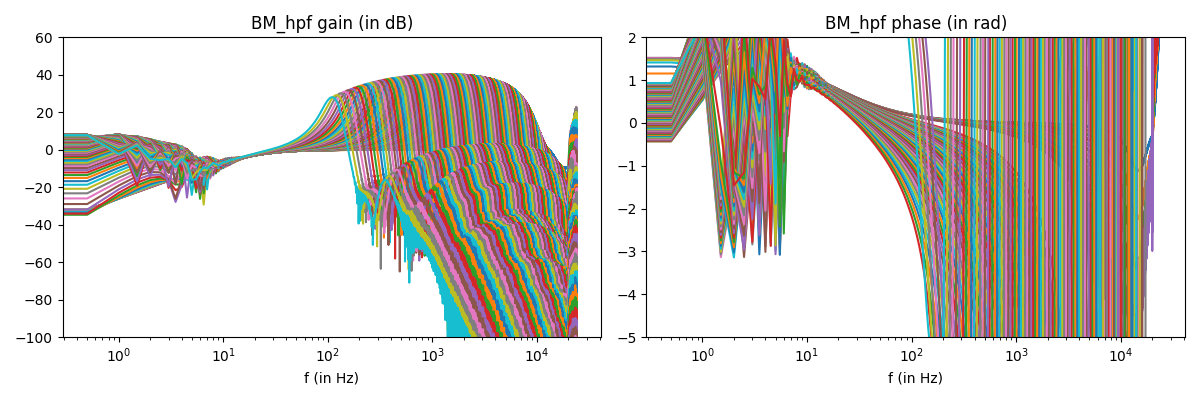

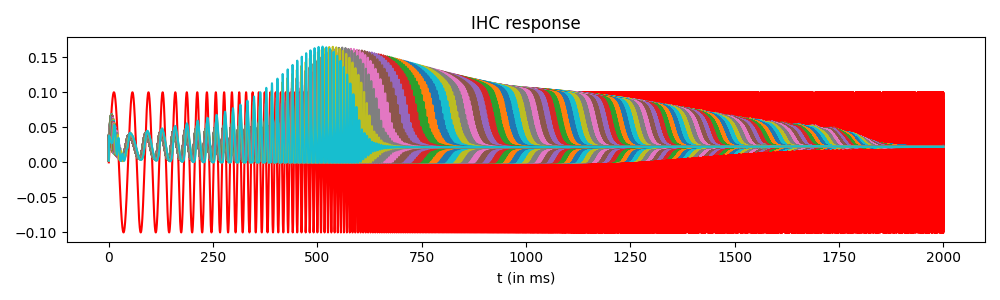

In [6]:
if fignum_exists(1): close(1)
fig1 = figure(1, figsize=(10, 4)) # Bode plot of BM displacement 
ax1 = fig1.add_subplot(1, 2, 1)
freq = linspace(0, fs // 2, npoints // 2)
semilogx(freq, 20 * log10(abs(myFFT.T[0 : npoints // 2, :]) + 1e-10))  
# note, 1e-10 offset to avoid division by zero in log10
title('BM_hpf gain (in dB)')
ylim([-100,60])
xlabel('f (in Hz)')
ax2 = subplot(1, 2, 2, sharex = ax1)
semilogx(freq, unwrap(angle(myFFT.T[0 : npoints // 2, :]), discont = 5, axis = 0))
title('BM_hpf phase (in rad)')
ylim([-5, 2])
xlabel('f (in Hz)')
tight_layout()

if fignum_exists(2): close(2)
figure(2, figsize=(10, 3)) # IHC output
plot(t1 * 1000, stimulus, 'r')
plot(t1 * 1000, IHC.T)
xlabel('t (in ms)')
title('IHC response')
tight_layout()

Note that at the start of the sweep, i.e., for the lowest input frequencies, you can clearly see the stronger response of the IHC to the start of the positive excursion of the sine wave, than to the later part. Also, as the sweep moves through the frequencies, one IHC after another reaches a maximum response, depending on which cochlear channel they are attached to. If we zoom in around 500ms we see this more clearly, with different coloured traces having the maximum response as the frequency of the input increases.

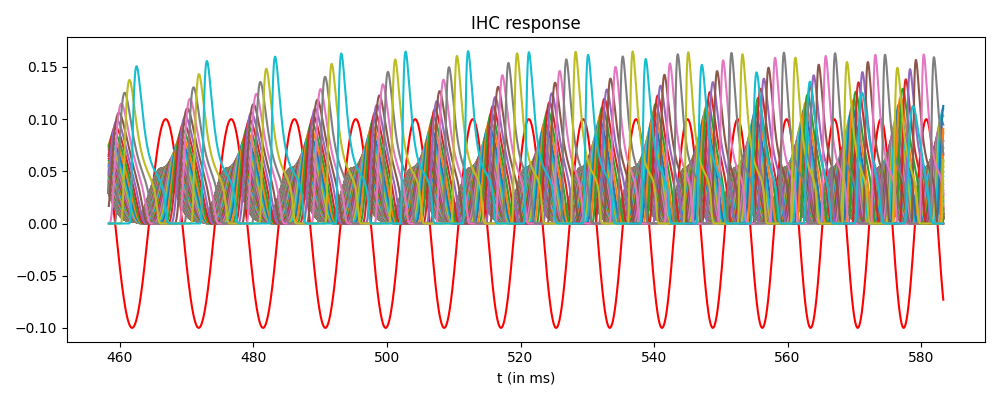

In [7]:
if fignum_exists(3): close(3)
figure(3, figsize=(10, 4))           # IHC output
plot(t1[22000 : 28000] * 1000, stimulus[22000 : 28000], 'r')
plot(t1[22000 : 28000] * 1000, IHC[:, 22000 : 28000].T)
xlabel('t (in ms)')
title('IHC response')
tight_layout()

At the high frequency end, 1.78 s into the sweep, we see that the response of section 5 is still getting stronger, while the response of section 10 is decreasing, and the response of section 15 is almost constant at the spontaneous level of the IHC. Remember that channel 0 is the highest frequency channel! (I have offset the stimulus by -0.1 for clarity in this plot.)

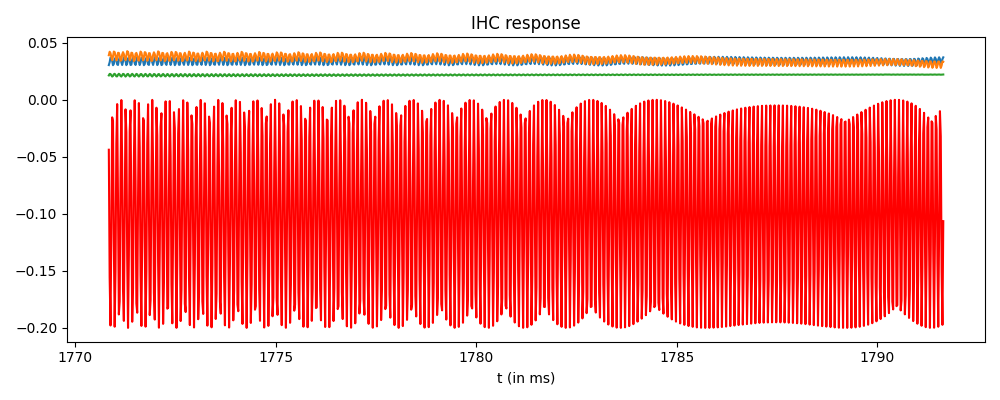

In [8]:
if fignum_exists(4): close(4)
figure(4, figsize=(10, 4))           # IHC output
plot(t1[85000 : 86000] * 1000, stimulus[85000 : 86000] - 0.1, 'r')
plot(t1[85000 : 86000] * 1000, IHC[5:16:5, 85000 : 86000].T)
xlabel('t (in ms)')
title('IHC response')
tight_layout()

Finally, we add the [Automatic Gain Control](./CARFACAGC.ipynb) loop.